<a href="https://colab.research.google.com/github/zhangs22/radioml_edge_training/blob/main/rml_training_alex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pickle, random
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("/content/drive/My Drive/Colab Notebooks/RML2016.10a/RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
dr = 0.5 # dropout rate (%)
model = keras.Sequential()
model.add(layers.Reshape(in_shp+[1], input_shape=in_shp))
# model.add(layers.ZeroPadding2D((0, 2)))
model.add(layers.Conv2D(96, kernel_size=(1, 11), activation="relu"))
# model.add(layers.ZeroPadding2D((0, 2)))
model.add(layers.Conv2D(256, kernel_size=(1, 5), activation="relu"))
# model.add(layers.ZeroPadding2D((0, 2)))
model.add(layers.Conv2D(384, kernel_size=(1, 3), activation="relu"))
model.add(layers.Conv2D(384, kernel_size=(1, 3), activation="relu"))
model.add(layers.Conv2D(256, kernel_size=(2, 3), activation="relu"))
model.add(layers.Dropout(dr))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(dr))
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dense(len(classes), activation="softmax"))
model.add(layers.Reshape([len(classes)]))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 118, 96)        1152      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 114, 256)       123136    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 112, 384)       295296    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 110, 384)       442752    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 108, 256)       590080    
_________________________________________________________________
dropout (Dropout)            (None, 1, 108, 256)       0

In [ ]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
history = model.fit(X_train, Y_train, batch_size=batch_size, verbose=2, epochs=nb_epoch, validation_split=0.1)

Epoch 1/100
97/97 - 40s - loss: 2.1644 - accuracy: 0.1824 - val_loss: 1.7701 - val_accuracy: 0.3154
Epoch 2/100
97/97 - 25s - loss: 1.6612 - accuracy: 0.3518 - val_loss: 1.5205 - val_accuracy: 0.4059
Epoch 3/100
97/97 - 26s - loss: 1.4654 - accuracy: 0.4330 - val_loss: 1.3887 - val_accuracy: 0.4595
Epoch 4/100
97/97 - 26s - loss: 1.7279 - accuracy: 0.3599 - val_loss: 1.8999 - val_accuracy: 0.2912
Epoch 5/100
97/97 - 25s - loss: 1.5613 - accuracy: 0.3982 - val_loss: 1.3381 - val_accuracy: 0.4687
Epoch 6/100
97/97 - 25s - loss: 1.3528 - accuracy: 0.4740 - val_loss: 1.2935 - val_accuracy: 0.4861
Epoch 7/100
97/97 - 25s - loss: 1.3129 - accuracy: 0.4871 - val_loss: 1.2668 - val_accuracy: 0.5027
Epoch 8/100
97/97 - 26s - loss: 1.2781 - accuracy: 0.4999 - val_loss: 1.2593 - val_accuracy: 0.5068
Epoch 9/100
97/97 - 26s - loss: 1.2598 - accuracy: 0.5084 - val_loss: 1.2556 - val_accuracy: 0.5090
Epoch 10/100
97/97 - 26s - loss: 1.4445 - accuracy: 0.4546 - val_loss: 1.3586 - val_accuracy: 0.4746

Epoch 83/100
97/97 - 25s - loss: 0.3806 - accuracy: 0.8577 - val_loss: 1.5063 - val_accuracy: 0.5244
Epoch 84/100
97/97 - 25s - loss: 0.3740 - accuracy: 0.8616 - val_loss: 1.5049 - val_accuracy: 0.5261
Epoch 85/100
97/97 - 25s - loss: 0.3702 - accuracy: 0.8609 - val_loss: 1.5198 - val_accuracy: 0.5187
Epoch 86/100
97/97 - 25s - loss: 0.3678 - accuracy: 0.8631 - val_loss: 1.5197 - val_accuracy: 0.5246
Epoch 87/100
97/97 - 25s - loss: 0.3578 - accuracy: 0.8662 - val_loss: 1.5518 - val_accuracy: 0.5239
Epoch 88/100
97/97 - 25s - loss: 0.3538 - accuracy: 0.8672 - val_loss: 1.5485 - val_accuracy: 0.5203
Epoch 89/100
97/97 - 25s - loss: 0.3414 - accuracy: 0.8721 - val_loss: 1.5346 - val_accuracy: 0.5230
Epoch 90/100
97/97 - 25s - loss: 0.3388 - accuracy: 0.8730 - val_loss: 1.5314 - val_accuracy: 0.5225
Epoch 91/100
97/97 - 26s - loss: 0.3309 - accuracy: 0.8749 - val_loss: 1.5525 - val_accuracy: 0.5200
Epoch 92/100
97/97 - 26s - loss: 0.3307 - accuracy: 0.8754 - val_loss: 1.5405 - val_accurac

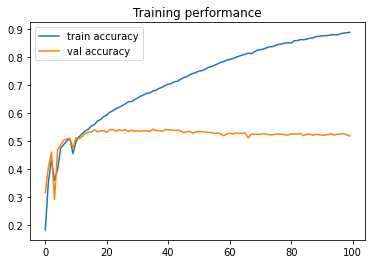

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['accuracy'], label='train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
plt.legend()

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.5681959390640259
Test accuracy: 0.5232636332511902


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

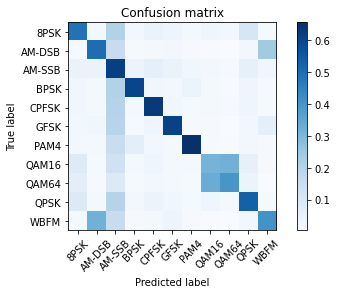

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09112534309240622
Overall Accuracy:  0.09355131698455948
Overall Accuracy:  0.09732272069464544
Overall Accuracy:  0.10862504511006857
Overall Accuracy:  0.14366453965360074
Overall Accuracy:  0.20170606006753156
Overall Accuracy:  0.3071835384898034
Overall Accuracy:  0.4404325513196481
Overall Accuracy:  0.5696857670979667
Overall Accuracy:  0.6884978229317852
Overall Accuracy:  0.7501824817518248
Overall Accuracy:  0.7684478371501272
Overall Accuracy:  0.7742290748898678
Overall Accuracy:  0.7819494584837545
Overall Accuracy:  0.769702434625789
Overall Accuracy:  0.7799635701275045
Overall Accuracy:  0.7749411551692921
Overall Accuracy:  0.7757888909392877
Overall Accuracy:  0.7737556561085973
Overall Accuracy:  0.78001800180018


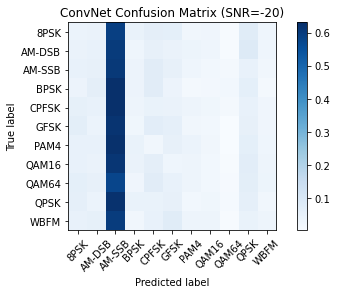

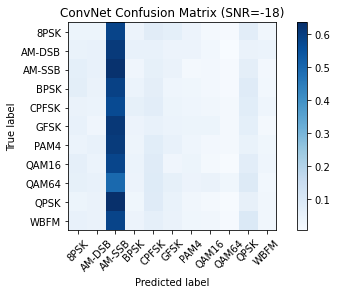

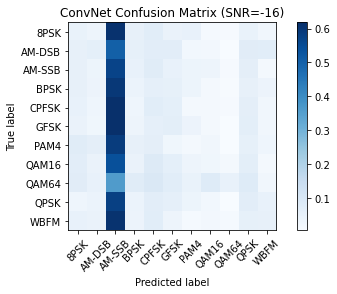

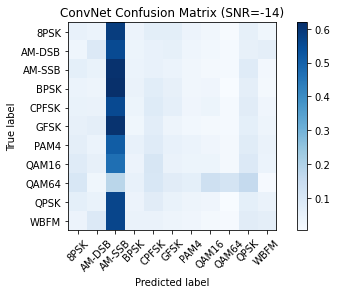

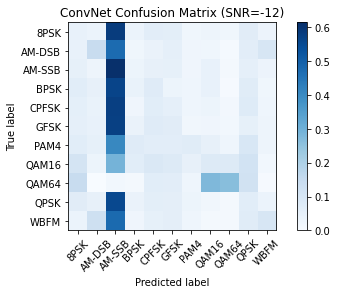

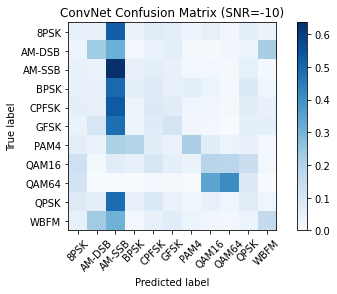

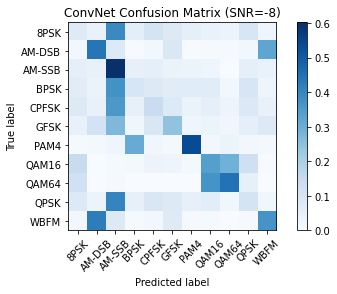

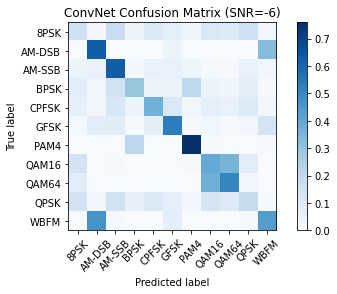

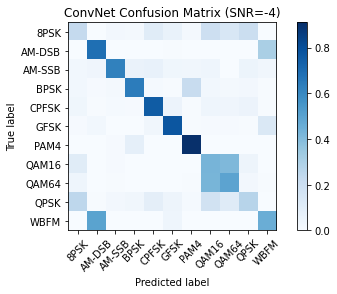

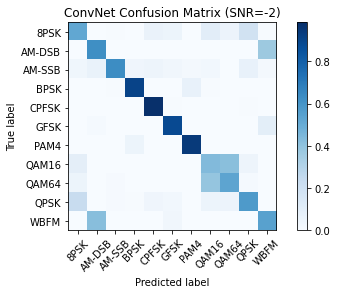

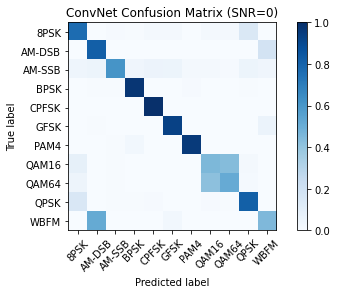

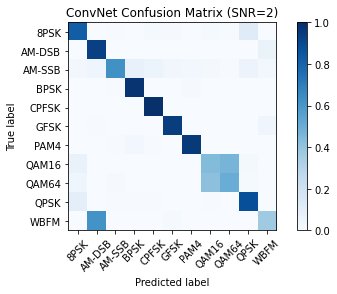

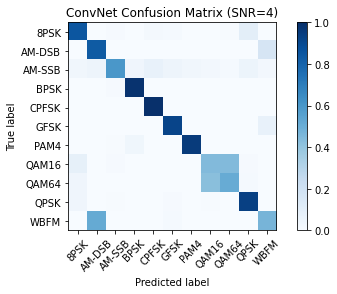

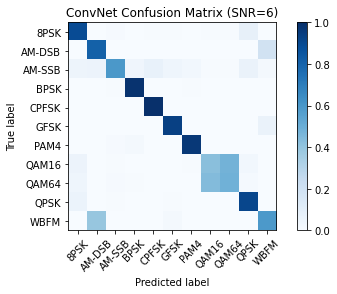

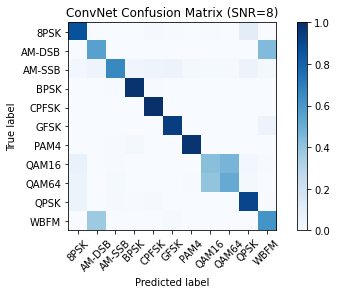

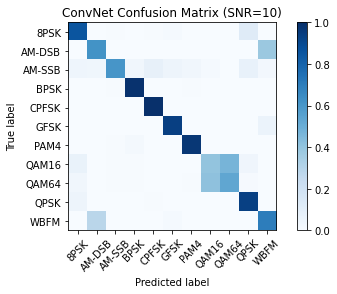

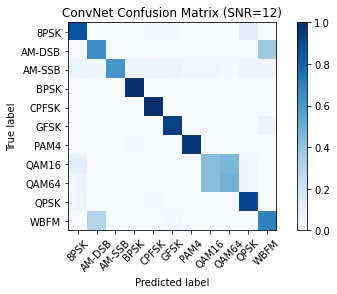

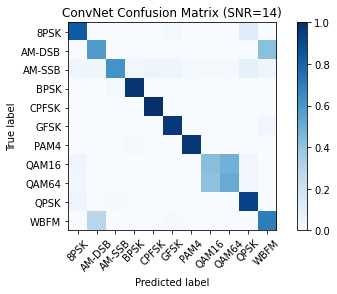

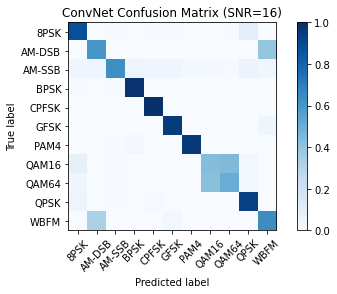

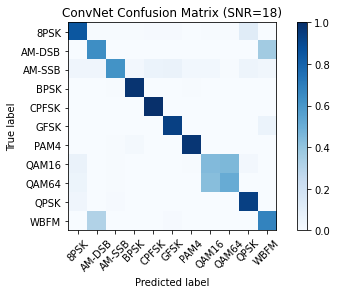

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

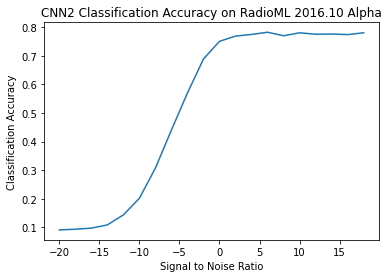

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")